In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:3


In [10]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

# Hyperparameter optimized for 9/7

# args = {
#     'processor':         'GENConv',
#     'head':              'regression',     
#     'num_layers':        4,
#     'num_mlp_layers':    2,
#     'aggr':              'max',
#     'batch_size':        8,
#     'node_feature_dim':  5,
#     'edge_feature_dim':  1,
#     'graph_feature_dim': 2,
#     'hidden_dim':        58,
#     'output_dim':        1,
#     'dropout':           0.066,
#     'epochs':            80,
#     'opt':               'adagrad',
#     'opt_scheduler':     'none',
#     'opt_restart':       0,
#     'weight_decay':      5e-3,
#     'lr':                0.0022434,
#     'device':            device,
#     'noise':             0 # Set to 0 to not train on noisy features
# }

# Hyperparam optimized for 6,10

args = {
    'processor':         'GENConv',
    'head':              'regression',     
    'num_layers':        5,
    'num_mlp_layers':    5,
    'aggr':              'max',
    'batch_size':        2,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        128,
    'output_dim':        1,
    'dropout':           0.0115,
    'epochs':            32,
    'opt':               'adagrad',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0083,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

# Hyperparam optimized for 10,6

# args = {
#     'processor':         'GENConv',
#     'head':              'regression',     
#     'num_layers':        3,
#     'num_mlp_layers':    3,
#     'aggr':              'max',
#     'batch_size':        8,
#     'node_feature_dim':  5,
#     'edge_feature_dim':  1,
#     'graph_feature_dim': 2,
#     'hidden_dim':        32,
#     'output_dim':        1,
#     'dropout':           0.0306,
#     'epochs':            64,
#     'opt':               'adagrad',
#     'opt_scheduler':     'none',
#     'opt_restart':       0,
#     'weight_decay':      5e-3,
#     'lr':                0.0121,
#     'device':            device,
#     'noise':             0 # Set to 0 to not train on noisy features
# }

In [31]:
train_num = 200; test_num = 100
node_config = (6,10)

# er_config = {
#     'graph_type': 'ER',
#     'p': 0.75,
#     'weighted': True
# }
# ba_config = {
#     'graph_type': 'BA',
#     'ba_param': 2,
#     'weighted': True
# }
# geom_config = {
#     'graph_type': 'GEOM',
#     'threshold': 0.2,
#     'scaling': 1 / np.sqrt(2)
# }

# train_instances = [
#         *ig.sample_instances(*node_config, train_num, rng, args, **er_config),
#         *ig.sample_instances(*node_config, train_num, rng, args, **ba_config),
#         *ig.sample_instances(*node_config, train_num, rng, args, **geom_config),
#     ]

# test_instances = [
#         *ig.sample_instances(*node_config, test_num, rng, args, **er_config),
#         *ig.sample_instances(*node_config, test_num, rng, args, **ba_config),
#         *ig.sample_instances(*node_config, test_num, rng, args, **geom_config),
#     ]

node_configs = util.node_configs_gnn1

rng = np.random.default_rng()


train_instances = [
        ig.sample_instances(node_config[0], node_config[1], train_num, rng, args, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]
test_instances = [
        ig.sample_instances(node_config[0], node_config[1], test_num, rng, args, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]
# flat map the instances
train_instances = [instance for instances in train_instances for instance in instances]
test_instances = [instance for instances in test_instances for instance in instances]

train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

KeyboardInterrupt: 

In [12]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


TRAINING LOSS: 0.028850805054291963


Training:   2%|▏         | 1/64 [00:18<19:09, 18.24s/Epochs]

TEST LOSS: 0.011462138034403324
TEST ACCURACY: 0.8618913888931274


Training:   3%|▎         | 2/64 [00:31<15:31, 15.02s/Epochs]

TRAINING LOSS: 0.014420568845636205


Training:   5%|▍         | 3/64 [00:44<14:24, 14.18s/Epochs]

TRAINING LOSS: 0.01246313517299067


Training:   6%|▋         | 4/64 [00:57<13:53, 13.90s/Epochs]

TRAINING LOSS: 0.011122692774260066
TRAINING LOSS: 0.01135940055338314


Training:   8%|▊         | 5/64 [01:17<15:50, 16.11s/Epochs]

TEST LOSS: 0.007629333063960075
TEST ACCURACY: 0.8796816468238831


Training:   9%|▉         | 6/64 [01:31<14:45, 15.26s/Epochs]

TRAINING LOSS: 0.010886654084933518


Training:  11%|█         | 7/64 [01:44<13:49, 14.55s/Epochs]

TRAINING LOSS: 0.010118755225479968


Training:  12%|█▎        | 8/64 [01:58<13:26, 14.40s/Epochs]

TRAINING LOSS: 0.010081936899630517
TRAINING LOSS: 0.010044732564482075


Training:  14%|█▍        | 9/64 [02:17<14:25, 15.74s/Epochs]

TEST LOSS: 0.01670609414577484
TEST ACCURACY: 0.8501873016357422


Training:  16%|█▌        | 10/64 [02:30<13:36, 15.11s/Epochs]

TRAINING LOSS: 0.009795618658289628


Training:  17%|█▋        | 11/64 [02:43<12:47, 14.49s/Epochs]

TRAINING LOSS: 0.009336226979718911


Training:  19%|█▉        | 12/64 [02:56<12:01, 13.88s/Epochs]

TRAINING LOSS: 0.009306606078573936
TRAINING LOSS: 0.009223970913363763


Training:  20%|██        | 13/64 [03:13<12:40, 14.92s/Epochs]

TEST LOSS: 0.012229776941239834
TEST ACCURACY: 0.8857678174972534


Training:  22%|██▏       | 14/64 [03:26<11:59, 14.39s/Epochs]

TRAINING LOSS: 0.009120951138622796


Training:  23%|██▎       | 15/64 [03:41<11:43, 14.35s/Epochs]

TRAINING LOSS: 0.009107687854257623


Training:  25%|██▌       | 16/64 [03:53<11:06, 13.89s/Epochs]

TRAINING LOSS: 0.008690500047164906
TRAINING LOSS: 0.008741241584308673


Training:  27%|██▋       | 17/64 [04:13<12:05, 15.44s/Epochs]

TEST LOSS: 0.00981796532869339
TEST ACCURACY: 0.8773408532142639


Training:  28%|██▊       | 18/64 [04:25<11:14, 14.66s/Epochs]

TRAINING LOSS: 0.00872619575467724


Training:  30%|██▉       | 19/64 [04:38<10:34, 14.10s/Epochs]

TRAINING LOSS: 0.008494508219115153


Training:  31%|███▏      | 20/64 [04:51<10:07, 13.80s/Epochs]

TRAINING LOSS: 0.008807655271656856
TRAINING LOSS: 0.008197312576571691


Training:  33%|███▎      | 21/64 [05:10<11:01, 15.38s/Epochs]

TEST LOSS: 0.008266539312899113
TEST ACCURACY: 0.8834269642829895


Training:  34%|███▍      | 22/64 [05:24<10:20, 14.77s/Epochs]

TRAINING LOSS: 0.008350407883474008


Training:  36%|███▌      | 23/64 [05:37<09:48, 14.34s/Epochs]

TRAINING LOSS: 0.008047851634940489


Training:  38%|███▊      | 24/64 [05:50<09:21, 14.04s/Epochs]

TRAINING LOSS: 0.00837114258760124
TRAINING LOSS: 0.00808062977050056


Training:  39%|███▉      | 25/64 [06:08<09:53, 15.21s/Epochs]

TEST LOSS: 0.007144153583794832
TEST ACCURACY: 0.8852996230125427


Training:  41%|████      | 26/64 [06:21<09:14, 14.60s/Epochs]

TRAINING LOSS: 0.008150270580938345


Training:  42%|████▏     | 27/64 [06:36<09:02, 14.65s/Epochs]

TRAINING LOSS: 0.00820444961095135


Training:  44%|████▍     | 28/64 [06:50<08:41, 14.50s/Epochs]

TRAINING LOSS: 0.00823113216250412
TRAINING LOSS: 0.007968295153907755


Training:  45%|████▌     | 29/64 [07:10<09:16, 15.91s/Epochs]

TEST LOSS: 0.0064885239116847515
TEST ACCURACY: 0.8848314881324768


Training:  47%|████▋     | 30/64 [07:23<08:31, 15.05s/Epochs]

TRAINING LOSS: 0.007697750890589777


Training:  48%|████▊     | 31/64 [07:36<08:03, 14.64s/Epochs]

TRAINING LOSS: 0.008068742978597587


Training:  50%|█████     | 32/64 [07:50<07:34, 14.21s/Epochs]

TRAINING LOSS: 0.007868144922204109
TRAINING LOSS: 0.007906124645030784


Training:  52%|█████▏    | 33/64 [08:08<08:04, 15.62s/Epochs]

TEST LOSS: 0.005923676770180464
TEST ACCURACY: 0.891853928565979


Training:  53%|█████▎    | 34/64 [08:21<07:19, 14.66s/Epochs]

TRAINING LOSS: 0.007739094291952734


Training:  55%|█████▍    | 35/64 [08:34<06:52, 14.21s/Epochs]

TRAINING LOSS: 0.007811329378959211


Training:  56%|█████▋    | 36/64 [08:48<06:32, 14.01s/Epochs]

TRAINING LOSS: 0.007760728744055604
TRAINING LOSS: 0.007853148598531002


Training:  58%|█████▊    | 37/64 [09:06<06:57, 15.46s/Epochs]

TEST LOSS: 0.007013262249529362
TEST ACCURACY: 0.8857678174972534


Training:  59%|█████▉    | 38/64 [09:21<06:35, 15.19s/Epochs]

TRAINING LOSS: 0.007668244523696822


Training:  61%|██████    | 39/64 [09:34<06:05, 14.62s/Epochs]

TRAINING LOSS: 0.007799954215780574


Training:  62%|██████▎   | 40/64 [09:47<05:38, 14.09s/Epochs]

TRAINING LOSS: 0.007565395965241335
TRAINING LOSS: 0.00755600389468234


Training:  64%|██████▍   | 41/64 [10:05<05:51, 15.30s/Epochs]

TEST LOSS: 0.008346356451511383
TEST ACCURACY: 0.8951311111450195


Training:  66%|██████▌   | 42/64 [10:18<05:21, 14.63s/Epochs]

TRAINING LOSS: 0.007606427620519944


Training:  67%|██████▋   | 43/64 [10:31<04:58, 14.19s/Epochs]

TRAINING LOSS: 0.007263321965780185


Training:  69%|██████▉   | 44/64 [10:44<04:34, 13.71s/Epochs]

TRAINING LOSS: 0.007537683884508371
TRAINING LOSS: 0.007670662055924724


Training:  70%|███████   | 45/64 [11:02<04:44, 14.97s/Epochs]

TEST LOSS: 0.00673783989623189
TEST ACCURACY: 0.8857678174972534


Training:  72%|███████▏  | 46/64 [11:15<04:16, 14.27s/Epochs]

TRAINING LOSS: 0.007377504576629294


Training:  73%|███████▎  | 47/64 [11:28<03:56, 13.91s/Epochs]

TRAINING LOSS: 0.007441875148100451


Training:  75%|███████▌  | 48/64 [11:41<03:38, 13.67s/Epochs]

TRAINING LOSS: 0.0074695075839736865
TRAINING LOSS: 0.007349478578115136


Training:  77%|███████▋  | 49/64 [11:59<03:43, 14.91s/Epochs]

TEST LOSS: 0.0068368748761713505
TEST ACCURACY: 0.8932584524154663


Training:  78%|███████▊  | 50/64 [12:12<03:21, 14.38s/Epochs]

TRAINING LOSS: 0.007342615678952064


Training:  80%|███████▉  | 51/64 [12:26<03:04, 14.22s/Epochs]

TRAINING LOSS: 0.007318576085203543


Training:  81%|████████▏ | 52/64 [12:38<02:45, 13.79s/Epochs]

TRAINING LOSS: 0.0073549690732256
TRAINING LOSS: 0.007461235700355026


Training:  83%|████████▎ | 53/64 [12:57<02:47, 15.25s/Epochs]

TEST LOSS: 0.006041478831321001
TEST ACCURACY: 0.887172281742096


Training:  84%|████████▍ | 54/64 [13:10<02:25, 14.58s/Epochs]

TRAINING LOSS: 0.007329630756946356


Training:  86%|████████▌ | 55/64 [13:23<02:07, 14.17s/Epochs]

TRAINING LOSS: 0.007329738154714323


Training:  88%|████████▊ | 56/64 [13:36<01:51, 13.88s/Epochs]

TRAINING LOSS: 0.007212535845351792
TRAINING LOSS: 0.007491398314180777


Training:  89%|████████▉ | 57/64 [13:54<01:43, 14.84s/Epochs]

TEST LOSS: 0.007619963958859444
TEST ACCURACY: 0.8810861706733704


Training:  91%|█████████ | 58/64 [14:07<01:26, 14.35s/Epochs]

TRAINING LOSS: 0.007297848047512253


Training:  92%|█████████▏| 59/64 [14:21<01:11, 14.23s/Epochs]

TRAINING LOSS: 0.007153117302340182


Training:  94%|█████████▍| 60/64 [14:35<00:56, 14.21s/Epochs]

TRAINING LOSS: 0.007188520581802345
TRAINING LOSS: 0.007242255450129418


Training:  95%|█████████▌| 61/64 [14:52<00:45, 15.04s/Epochs]

TEST LOSS: 0.0069217924028635025
TEST ACCURACY: 0.8904494643211365


Training:  97%|█████████▋| 62/64 [15:04<00:28, 14.30s/Epochs]

TRAINING LOSS: 0.007271020632637275


Training:  98%|█████████▊| 63/64 [15:18<00:14, 14.19s/Epochs]

TRAINING LOSS: 0.00715948293578657


Training: 100%|██████████| 64/64 [15:31<00:00, 14.56s/Epochs]

TRAINING LOSS: 0.007299659005355299


In [9]:
save(GNN, args, 'GNN2_hyperparam_tuned')

In [ ]:
# GNN, args = load('GNN2', device)

In [ ]:
from gnn_library.OBM_greedy import OBM_Greedy
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = [(threshold, OBM_Threshold_Greedy(threshold)) for threshold in thresholds]

seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

greedy_ratios = {}
for threshold, model in thresholded_greedy_models: 
    ratio = evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=eval_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
pp_output(ratios2, _, show_log=False)
print(greedy_ratios)

In [ ]:
max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(max_threshold, greedy_ratios[max_threshold])

# Pivot to feature-generated graphs

In [ ]:
def get_location_graph(city):
	location_graph = ox.graph_from_place(city, network_type="drive")
	location_graph = ox.speed.add_edge_speeds(location_graph)
	location_graph = ox.speed.add_edge_travel_times(location_graph)
	return {'location_graph': location_graph, 'city': city}

In [ ]:
piedmont = get_location_graph("Piedmont, California, USA")
# san_francisco = get_location_graph("San Francisco, California, USA")
founex = get_location_graph("Founex, Switzerland")
carmel = get_location_graph("Carmel, Indiana, USA")
geneva = get_location_graph("Geneva, Switzerland")

In [ ]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 0.75,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
# osmnx_config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **er_config),
        *ig.sample_instances(8, 8, train_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(8, 8, test_num, rng, **er_config),
        *ig.sample_instances(8, 8, test_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [22]:
from tqdm import tqdm
import util
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

# osmnx_config1 = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# osmnx_config2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': geneva['location_graph']
# }
# osmnx_config3 = {
#     'graph_type': 'OSMNX',
#     'location_graph': carmel['location_graph']
# }

node_configs = util.node_configs_GNN1
graph_configs = util.graph_configs_standard
train_num = 5
train_instances = [
        ig.sample_instances(node_config[0], node_config[1], train_num, rng, args.__dict__, **graph_config)
        for graph_config in graph_configs
        for node_config in node_configs
]

# flat map the train instances
train_instances = [instance for instances in train_instances for instance in instances]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio, _ = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio['learned'])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

100%|██████████| 101/101 [29:33<00:00, 17.56s/it]

Best threshold value: 0.0 achieves CR: 0.05581373962215269


In [16]:
print(greedy_ratios)

{0.0: 0.991188005856922, 0.01: 0.991188005856922, 0.02: 0.991188005856922, 0.03: 0.991188005856922, 0.04: 0.991188005856922, 0.05: 0.991188005856922, 0.06: 0.991188005856922, 0.07: 0.991188005856922, 0.08: 0.991188005856922, 0.09: 0.991188005856922, 0.1: 0.991188005856922, 0.11: 0.991188005856922, 0.12: 0.991188005856922, 0.13: 0.991188005856922, 0.14: 0.991188005856922, 0.15: 0.991188005856922, 0.16: 0.991188005856922, 0.17: 0.991188005856922, 0.18: 0.991188005856922, 0.19: 0.991188005856922, 0.2: 0.991188005856922, 0.21: 0.991188005856922, 0.22: 0.991188005856922, 0.23: 0.991188005856922, 0.24: 0.991188005856922, 0.25: 0.9902019295044397, 0.26: 0.9902019295044397, 0.27: 0.9902019295044397, 0.28: 0.9902019295044397, 0.29: 0.9902019295044397, 0.3: 0.9902019295044397, 0.31: 0.9902019295044397, 0.32: 0.9902019295044397, 0.33: 0.9902019295044397, 0.34: 0.9902019295044397, 0.35000000000000003: 0.9902019295044397, 0.36: 0.9902019295044397, 0.37: 0.9902019295044397, 0.38: 0.9843320526626002,

## Evaluation

In [ ]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 25
eval_instances = [
        *ig.sample_instances(m, n, eval_num, rng, **er_config),
        *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
]

ratios = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)


ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[THRESHOLD_MODEL],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)
print(f"Thresholded greedy: {np.mean(ratios2[0]).round(4)}")


## Box plot baseline evaluation

In [4]:
GNN, args = load('GNN1_hyperparam_tuned', device)

In [32]:
import gnn_library.util as util
num_trials = 40
threshold = 0 # TODO set up value
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

models = [("GNN", GNN)]
t_greedy = OBM_Threshold_Greedy(threshold) 

node_configs = util.node_configs_gnn1
graph_configs = util.graph_configs_standard

data = {node_config: {} for node_config in node_configs}

for node_config in node_configs:
    for graph_config in graph_configs:
            print(graph_config)
            seed = np.random.randint(0, 500000)
            rng = np.random.default_rng(seed)
            instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


            rng = np.random.default_rng(seed)

            for model_name, model in models:
                cr_ratios, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[model],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=5,
                    baselines=['greedy', 'lp_rounding'],
                )

                data[node_config][graph_config['graph_type']] = cr_ratios

                t_greedy_ratio, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[t_greedy],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=5,
                )

                # Threshold greedy is considered as a model here
                data[node_config][graph_config['graph_type']]['threshold_greedy'] = t_greedy_ratio['learned']


{'graph_type': 'ER', 'p': 0.5, 'weighted': True}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'graph_type': 'ER', 'p': 0.75, 'weighted': True}
{'graph_type': 'ER', 'p': 0.9, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
{'graph_type': 'OSMNX', 'location': 'Piedmont, California, USA'}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
{'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'graph_type': 'ER', 'p': 0.5, 'weighted': True}
{'graph_type': 'ER', 'p': 0.75, 'weighted': True}
{'graph_type': 'ER', 'p': 0.9, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
{'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
{'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
{'graph_type': 'OSMNX', 'location': 'Piedmont, California, USA'}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
{'graph_type': 'GM'}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
import pickle

with open(f"saved_runs/box_plot_eval_gnn1_base_2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open(f'saved_runs/box_plot_eval_gnn1_base_2.pickle', 'rb') as handle:
    data_copy = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


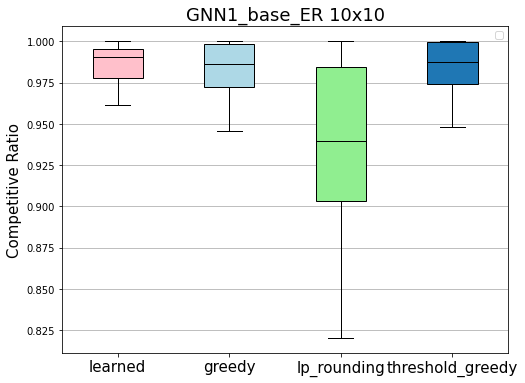

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


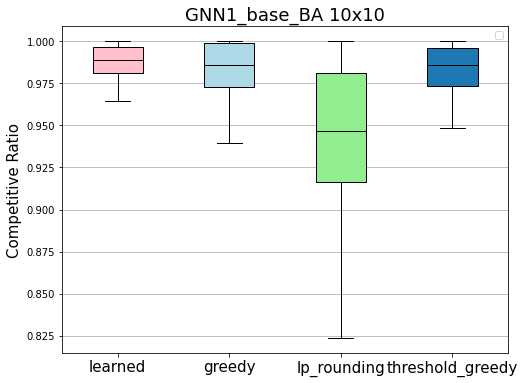

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


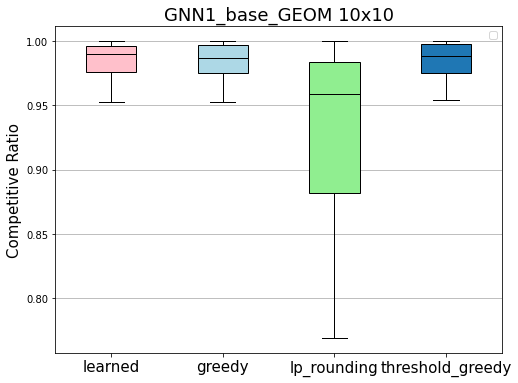

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


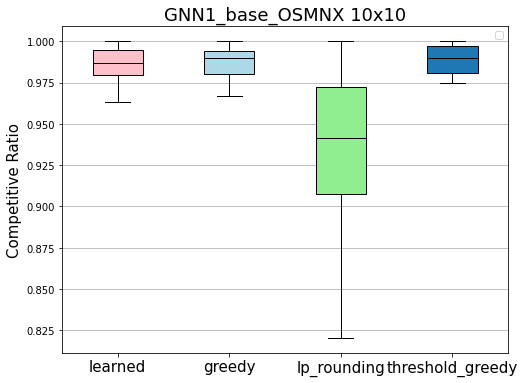

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


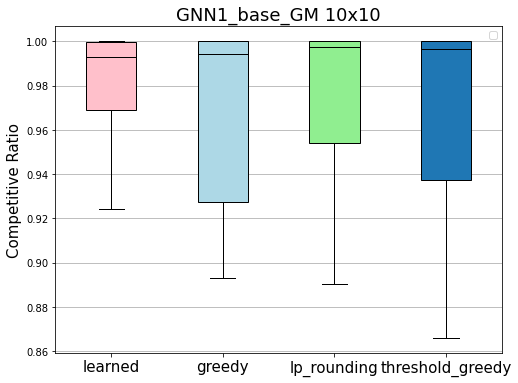

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


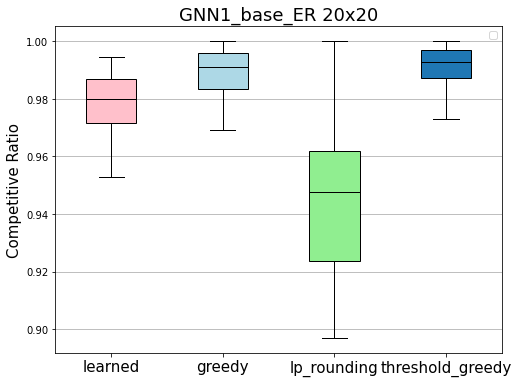

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


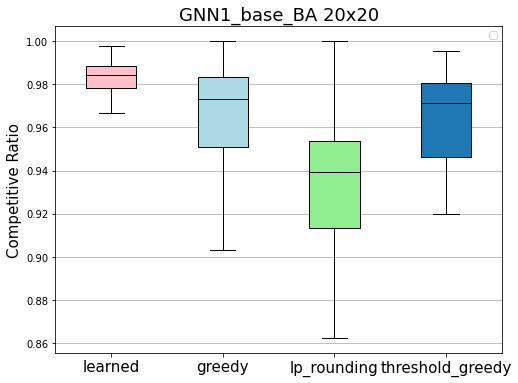

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


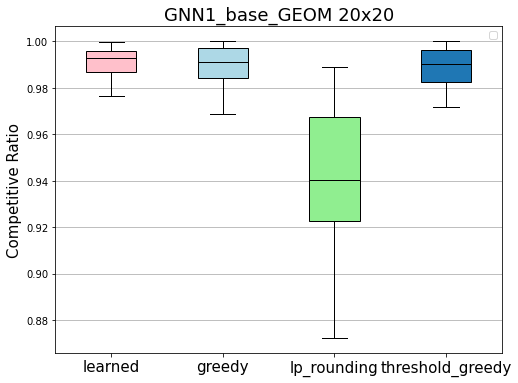

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


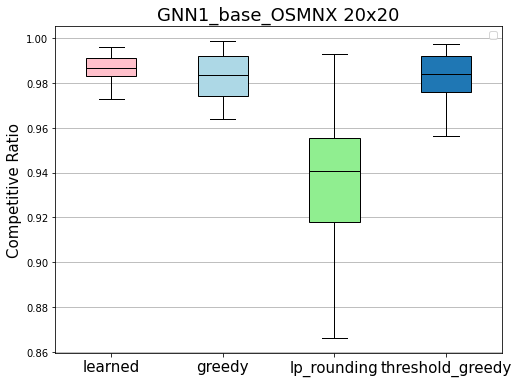

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3398: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(40, 4)


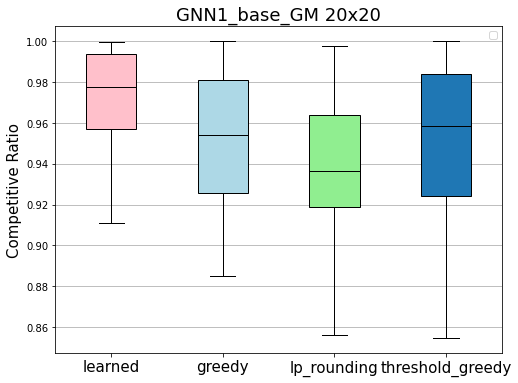

In [36]:
from util import _box_plots
for node_config in node_configs:
	_box_plots(data_copy[node_config], lambda graph_type: f"GNN1_base_{graph_type} {node_config[1]}x{node_config[0]}", colors = ['pink', 'lightblue', 'lightgreen'])

### Baseline ER/BA/GEOM evaluation

In [7]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 40, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

models = [("GNN", GNN)]

graph_configs = [
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    # {
    #     'graph_type': 'GEOM',
    #     'threshold': 0.2,
    #     'scaling': 1 / np.sqrt(2),
    #     'weighted': True
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


        rng = np.random.default_rng(seed)

        baselines = ['greedy']
        for model_name, model in models:
            cr_ratios = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[model],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                # baselines=['greedy', 'lp_rounding']
                baselines=baselines
            )

            baselines = []

            cr_ratios[model_name] = cr_ratios.pop("learned")

        data[graph_config['graph_type']].append(cr_ratios)

[0.25, 0.75, 1.25, 1.75, 2.25]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)


AttributeError: 'tuple' object has no attribute 'pop'

In [ ]:
from util import _plot_approx_ratios
_plot_approx_ratios(ratios, data, lambda graph_type: graph_type, confidence = 0.95)

In [ ]:
import matplotlib.pyplot as plt

ratios = [x/y for (x,y) in node_configs]

for graph_type, comp_ratios in data.items():
    aggregated_ratios = {}

    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

    fig = plt.figure(figsize=(8,6))
    for model, model_ratios in aggregated_ratios.items():
        plt.plot(ratios, model_ratios, label=model)

    title = f"{graph_type}"
    plt.title(title)
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/17_01_2024_{title}_no_probabilities.png")
    plt.show()


## Noise experiments

In [3]:
def create_noise_robust_models(noise_values):
    models = []
    for noise_value in noise_values:
        print(f"Training model for noise {noise_value}")
        args = {
            'processor':         'GENConv',
            'head':              'regression',     
            'num_layers':        3,
            'num_mlp_layers':    3,
            'aggr':              'max',
            'batch_size':        8,
            'node_feature_dim':  5,
            'edge_feature_dim':  1,
            'graph_feature_dim': 2,
            'hidden_dim':        32,
            'output_dim':        1,
            'dropout':           0.0306,
            'epochs':            64,
            'opt':               'adagrad',
            'opt_scheduler':     'none',
            'opt_restart':       0,
            'weight_decay':      5e-3,
            'lr':                0.0121,
            'device':            device,
            'noise':             noise_value # Set to 0 to not train on noisy features
        }

        train_num = 100; test_num = 30

        er_config = {
            'graph_type': 'ER',
            'p': 0.75,
            'weighted': True
        }
        ba_config = {
            'graph_type': 'BA',
            'ba_param': 4,
            'weighted': True
        }
        geom_config = {
            'graph_type': 'GEOM',
            'q': 0.25,
            'd': 2,
            'weighted': True
        }

        rng = np.random.default_rng()

        node_config = (10,6)

        train_instances = [
                *ig.sample_instances(*node_config, train_num, rng, args, **er_config),
                *ig.sample_instances(*node_config, train_num, rng, args, **ba_config),
                *ig.sample_instances(*node_config, train_num, rng, args, **geom_config),
            ]

        test_instances = [
                *ig.sample_instances(*node_config, test_num, rng, args, **er_config),
                *ig.sample_instances(*node_config, test_num, rng, args, **ba_config),
                *ig.sample_instances(*node_config, test_num, rng, args, **geom_config),
            ]


        train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
        test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

        train_loader = DataLoader(
            train_data,
            batch_size=args['batch_size'],
            shuffle=True,
            num_workers=4
        )

        test_loader = DataLoader(
            test_data,
            batch_size=args['batch_size'],
            shuffle=True,
            num_workers=4
        )


        _, _, _, GNN, _ = train(train_loader, test_loader, args)

        save(GNN, args, f'GNN_noise_{noise_value}')

        models.append((f"GNN_{args['noise']}", GNN))
    return models

In [4]:
noise_values = np.linspace(0,3,20)[:5]
# print(noise_values)
models = create_noise_robust_models(noise_values)
# models = [GNN] * len(noise_values) # TODO change this

Training model for noise 0.0


Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


TRAINING LOSS: 0.049393070578054823


Training:   2%|▏         | 1/64 [00:09<09:54,  9.44s/Epochs]

TEST LOSS: 0.021726159378886223
TEST ACCURACY: 0.8870967626571655


Training:   3%|▎         | 2/64 [00:16<08:34,  8.30s/Epochs]

TRAINING LOSS: 0.023474673663783606


Training:   5%|▍         | 3/64 [00:23<07:45,  7.64s/Epochs]

TRAINING LOSS: 0.019401982141646016


Training:   6%|▋         | 4/64 [00:31<07:31,  7.52s/Epochs]

TRAINING LOSS: 0.018429707941733785
TRAINING LOSS: 0.01680908545989012


Training:   8%|▊         | 5/64 [00:40<07:59,  8.13s/Epochs]

TEST LOSS: 0.014017689041793346
TEST ACCURACY: 0.8903225660324097


Training:   9%|▉         | 6/64 [00:46<07:18,  7.56s/Epochs]

TRAINING LOSS: 0.015557270169178626


Training:  11%|█         | 7/64 [00:53<07:04,  7.44s/Epochs]

TRAINING LOSS: 0.015278341045384553


Training:  12%|█▎        | 8/64 [01:01<06:51,  7.36s/Epochs]

TRAINING LOSS: 0.015048364020168608
TRAINING LOSS: 0.01403674389760504


Training:  14%|█▍        | 9/64 [01:09<07:00,  7.65s/Epochs]

TEST LOSS: 0.012394477613270283
TEST ACCURACY: 0.9145160913467407


Training:  16%|█▌        | 10/64 [01:16<06:46,  7.53s/Epochs]

TRAINING LOSS: 0.014043066942401296


Training:  17%|█▋        | 11/64 [01:24<06:37,  7.49s/Epochs]

TRAINING LOSS: 0.012920294811987074


Training:  19%|█▉        | 12/64 [01:31<06:23,  7.38s/Epochs]

TRAINING LOSS: 0.013661310856278433
TRAINING LOSS: 0.012712315592109058


Training:  20%|██        | 13/64 [01:40<06:48,  8.01s/Epochs]

TEST LOSS: 0.010531952604651451
TEST ACCURACY: 0.9161289930343628


Training:  22%|██▏       | 14/64 [01:47<06:27,  7.76s/Epochs]

TRAINING LOSS: 0.012490041812323575


Training:  23%|██▎       | 15/64 [01:54<06:10,  7.55s/Epochs]

TRAINING LOSS: 0.012510267324803467


Training:  25%|██▌       | 16/64 [02:02<05:57,  7.44s/Epochs]

TRAINING LOSS: 0.01189778766763748
TRAINING LOSS: 0.01210833602213634


Training:  27%|██▋       | 17/64 [02:11<06:17,  8.02s/Epochs]

TEST LOSS: 0.013057081028819084
TEST ACCURACY: 0.9193547964096069


Training:  28%|██▊       | 18/64 [02:18<06:01,  7.85s/Epochs]

TRAINING LOSS: 0.011809083218501102


Training:  30%|██▉       | 19/64 [02:26<05:42,  7.62s/Epochs]

TRAINING LOSS: 0.011646375575877011


Training:  31%|███▏      | 20/64 [02:33<05:33,  7.58s/Epochs]

TRAINING LOSS: 0.011549921209493039
TRAINING LOSS: 0.011789408073851804


Training:  33%|███▎      | 21/64 [02:42<05:48,  8.10s/Epochs]

TEST LOSS: 0.010252113454043865
TEST ACCURACY: 0.9274193644523621


Training:  34%|███▍      | 22/64 [02:50<05:30,  7.88s/Epochs]

TRAINING LOSS: 0.011187768697099098


Training:  36%|███▌      | 23/64 [02:57<05:18,  7.76s/Epochs]

TRAINING LOSS: 0.011564306781566716


Training:  38%|███▊      | 24/64 [03:04<05:02,  7.56s/Epochs]

TRAINING LOSS: 0.011309710779307711
TRAINING LOSS: 0.011545637412905463


Training:  39%|███▉      | 25/64 [03:13<05:10,  7.95s/Epochs]

TEST LOSS: 0.01319693773984909
TEST ACCURACY: 0.9290322661399841


Training:  41%|████      | 26/64 [03:20<04:48,  7.60s/Epochs]

TRAINING LOSS: 0.011184403927098855


Training:  42%|████▏     | 27/64 [03:27<04:30,  7.32s/Epochs]

TRAINING LOSS: 0.011004200444812413


Training:  44%|████▍     | 28/64 [03:34<04:20,  7.23s/Epochs]

TRAINING LOSS: 0.010770219317650934
TRAINING LOSS: 0.011076526195136062


Training:  45%|████▌     | 29/64 [03:43<04:31,  7.77s/Epochs]

TEST LOSS: 0.013527171686291695
TEST ACCURACY: 0.9112902879714966


Training:  47%|████▋     | 30/64 [03:50<04:16,  7.56s/Epochs]

TRAINING LOSS: 0.010315456477316343


Training:  48%|████▊     | 31/64 [03:57<04:07,  7.49s/Epochs]

TRAINING LOSS: 0.011058607753402365


Training:  50%|█████     | 32/64 [04:04<03:56,  7.41s/Epochs]

TRAINING LOSS: 0.010611708418698304
TRAINING LOSS: 0.010620576484448608


Training:  52%|█████▏    | 33/64 [04:14<04:09,  8.04s/Epochs]

TEST LOSS: 0.012581552378833294
TEST ACCURACY: 0.9193547964096069


Training:  53%|█████▎    | 34/64 [04:21<03:55,  7.84s/Epochs]

TRAINING LOSS: 0.010997506132246393


Training:  55%|█████▍    | 35/64 [04:29<03:43,  7.70s/Epochs]

TRAINING LOSS: 0.010646960250924908


Training:  56%|█████▋    | 36/64 [04:36<03:33,  7.63s/Epochs]

TRAINING LOSS: 0.010689106572032784
TRAINING LOSS: 0.010499385713981726


Training:  58%|█████▊    | 37/64 [04:45<03:37,  8.06s/Epochs]

TEST LOSS: 0.012988107278943062
TEST ACCURACY: 0.8887096643447876


Training:  59%|█████▉    | 38/64 [04:52<03:21,  7.77s/Epochs]

TRAINING LOSS: 0.01069503023933211


Training:  61%|██████    | 39/64 [04:59<03:10,  7.62s/Epochs]

TRAINING LOSS: 0.01002874873780892


Training:  62%|██████▎   | 40/64 [05:07<03:01,  7.55s/Epochs]

TRAINING LOSS: 0.010182206129617302
TRAINING LOSS: 0.010226832531125192


Training:  64%|██████▍   | 41/64 [05:16<03:06,  8.12s/Epochs]

TEST LOSS: 0.009079471230506897
TEST ACCURACY: 0.9112902879714966


Training:  66%|██████▌   | 42/64 [05:23<02:52,  7.86s/Epochs]

TRAINING LOSS: 0.01043540761091545


Training:  67%|██████▋   | 43/64 [05:31<02:41,  7.69s/Epochs]

TRAINING LOSS: 0.009873904185288312


Training:  69%|██████▉   | 44/64 [05:38<02:32,  7.65s/Epochs]

TRAINING LOSS: 0.010384994489886046
TRAINING LOSS: 0.010074747548818905


Training:  70%|███████   | 45/64 [05:47<02:32,  8.02s/Epochs]

TEST LOSS: 0.009164328686892986
TEST ACCURACY: 0.9290322661399841


Training:  72%|███████▏  | 46/64 [05:54<02:17,  7.62s/Epochs]

TRAINING LOSS: 0.009860030117974943


Training:  73%|███████▎  | 47/64 [06:01<02:08,  7.54s/Epochs]

TRAINING LOSS: 0.010317193784152096


Training:  75%|███████▌  | 48/64 [06:09<01:59,  7.50s/Epochs]

TRAINING LOSS: 0.009872345515787891
TRAINING LOSS: 0.009735825608884618


Training:  77%|███████▋  | 49/64 [06:18<02:01,  8.10s/Epochs]

TEST LOSS: 0.00873499270528555
TEST ACCURACY: 0.9290322661399841


Training:  78%|███████▊  | 50/64 [06:26<01:50,  7.89s/Epochs]

TRAINING LOSS: 0.00991949312358184


Training:  80%|███████▉  | 51/64 [06:33<01:40,  7.72s/Epochs]

TRAINING LOSS: 0.010047874673812584


Training:  81%|████████▏ | 52/64 [06:40<01:31,  7.66s/Epochs]

TRAINING LOSS: 0.009551721072198406
TRAINING LOSS: 0.009698771964668302


Training:  83%|████████▎ | 53/64 [06:50<01:30,  8.21s/Epochs]

TEST LOSS: 0.010416927747428417
TEST ACCURACY: 0.9193547964096069


Training:  84%|████████▍ | 54/64 [06:57<01:19,  7.96s/Epochs]

TRAINING LOSS: 0.009413072744982405


Training:  86%|████████▌ | 55/64 [07:05<01:10,  7.79s/Epochs]

TRAINING LOSS: 0.009666125291902446


Training:  88%|████████▊ | 56/64 [07:12<01:01,  7.66s/Epochs]

TRAINING LOSS: 0.00973962995839765
TRAINING LOSS: 0.009710919021635121


Training:  89%|████████▉ | 57/64 [07:21<00:57,  8.14s/Epochs]

TEST LOSS: 0.009085327386856079
TEST ACCURACY: 0.9225806593894958


Training:  91%|█████████ | 58/64 [07:29<00:48,  8.00s/Epochs]

TRAINING LOSS: 0.009804170640143923


Training:  92%|█████████▏| 59/64 [07:36<00:38,  7.79s/Epochs]

TRAINING LOSS: 0.00929376269689789


Training:  94%|█████████▍| 60/64 [07:44<00:30,  7.67s/Epochs]

TRAINING LOSS: 0.009465226209808275
TRAINING LOSS: 0.009325922726518922


Training:  95%|█████████▌| 61/64 [07:53<00:24,  8.10s/Epochs]

TEST LOSS: 0.0097269918769598
TEST ACCURACY: 0.9241935610771179


Training:  97%|█████████▋| 62/64 [08:00<00:15,  7.87s/Epochs]

TRAINING LOSS: 0.009303552039856475


Training:  98%|█████████▊| 63/64 [08:08<00:07,  7.79s/Epochs]

TRAINING LOSS: 0.009390046326380321


Training: 100%|██████████| 64/64 [08:15<00:00,  7.74s/Epochs]

TRAINING LOSS: 0.009760546379214086
Training model for noise 0.15789473684210525



Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

TRAINING LOSS: 0.04893902939737429


Training:   2%|▏         | 1/64 [00:09<09:54,  9.43s/Epochs]

TEST LOSS: 0.03870079666376114
TEST ACCURACY: 0.7885245680809021


Training:   3%|▎         | 2/64 [00:16<08:29,  8.21s/Epochs]

TRAINING LOSS: 0.03610498275131866


Training:   5%|▍         | 3/64 [00:24<08:06,  7.97s/Epochs]

TRAINING LOSS: 0.03375416399009471


Training:   6%|▋         | 4/64 [00:31<07:44,  7.74s/Epochs]

TRAINING LOSS: 0.033179723044871115
TRAINING LOSS: 0.03200048767945544


Training:   8%|▊         | 5/64 [00:41<08:07,  8.26s/Epochs]

TEST LOSS: 0.030018234625458717
TEST ACCURACY: 0.8065573573112488


Training:   9%|▉         | 6/64 [00:48<07:38,  7.91s/Epochs]

TRAINING LOSS: 0.03209083307104263


Training:  11%|█         | 7/64 [00:55<07:21,  7.74s/Epochs]

TRAINING LOSS: 0.03136778065170498


Training:  12%|█▎        | 8/64 [01:03<07:07,  7.63s/Epochs]

TRAINING LOSS: 0.030939854786751896
TRAINING LOSS: 0.030950412599951103


Training:  14%|█▍        | 9/64 [01:11<07:20,  8.00s/Epochs]

TEST LOSS: 0.049101926386356354
TEST ACCURACY: 0.796721339225769


Training:  16%|█▌        | 10/64 [01:19<07:01,  7.81s/Epochs]

TRAINING LOSS: 0.03041869952670626


Training:  17%|█▋        | 11/64 [01:26<06:46,  7.67s/Epochs]

TRAINING LOSS: 0.030181536475695322


Training:  19%|█▉        | 12/64 [01:33<06:31,  7.53s/Epochs]

TRAINING LOSS: 0.02923259633417065
TRAINING LOSS: 0.029308079314905536


Training:  20%|██        | 13/64 [01:42<06:47,  8.00s/Epochs]

TEST LOSS: 0.029364360496401787
TEST ACCURACY: 0.8163934350013733


Training:  22%|██▏       | 14/64 [01:50<06:27,  7.75s/Epochs]

TRAINING LOSS: 0.030213255376648845


Training:  23%|██▎       | 15/64 [01:57<06:17,  7.70s/Epochs]

TRAINING LOSS: 0.02990861527566828


Training:  25%|██▌       | 16/64 [02:05<06:05,  7.62s/Epochs]

TRAINING LOSS: 0.029050833865524216
TRAINING LOSS: 0.029169004297007507


Training:  27%|██▋       | 17/64 [02:14<06:16,  8.01s/Epochs]

TEST LOSS: 0.028440166264772415
TEST ACCURACY: 0.8213114738464355


Training:  28%|██▊       | 18/64 [02:21<05:56,  7.74s/Epochs]

TRAINING LOSS: 0.02852244048724889


Training:  30%|██▉       | 19/64 [02:28<05:45,  7.69s/Epochs]

TRAINING LOSS: 0.02862990617715463


Training:  31%|███▏      | 20/64 [02:36<05:33,  7.58s/Epochs]

TRAINING LOSS: 0.028149778902970015
TRAINING LOSS: 0.028466268352413646


Training:  33%|███▎      | 21/64 [02:45<05:49,  8.13s/Epochs]

TEST LOSS: 0.0418342761695385
TEST ACCURACY: 0.8032786846160889


Training:  34%|███▍      | 22/64 [02:52<05:31,  7.90s/Epochs]

TRAINING LOSS: 0.028096072121319666


Training:  36%|███▌      | 23/64 [03:00<05:18,  7.78s/Epochs]

TRAINING LOSS: 0.028618368675762958


Training:  38%|███▊      | 24/64 [03:07<05:01,  7.53s/Epochs]

TRAINING LOSS: 0.028099780176887496
TRAINING LOSS: 0.028165717723182142


Training:  39%|███▉      | 25/64 [03:16<05:12,  8.01s/Epochs]

TEST LOSS: 0.03233172371983528
TEST ACCURACY: 0.7836065292358398


Training:  41%|████      | 26/64 [03:23<04:52,  7.69s/Epochs]

TRAINING LOSS: 0.02759416594607092


Training:  42%|████▏     | 27/64 [03:30<04:37,  7.50s/Epochs]

TRAINING LOSS: 0.027696534613243486


Training:  44%|████▍     | 28/64 [03:37<04:30,  7.50s/Epochs]

TRAINING LOSS: 0.027610491695802392
TRAINING LOSS: 0.027572866580025716


Training:  45%|████▌     | 29/64 [03:46<04:36,  7.90s/Epochs]

TEST LOSS: 0.027673639357089996
TEST ACCURACY: 0.8262295126914978


Training:  47%|████▋     | 30/64 [03:53<04:18,  7.61s/Epochs]

TRAINING LOSS: 0.027436998759279674


Training:  48%|████▊     | 31/64 [04:00<04:06,  7.47s/Epochs]

TRAINING LOSS: 0.02732606813933984


Training:  50%|█████     | 32/64 [04:07<03:55,  7.37s/Epochs]

TRAINING LOSS: 0.02688633612235802
TRAINING LOSS: 0.026889127774818524


Training:  52%|█████▏    | 33/64 [04:16<04:04,  7.87s/Epochs]

TEST LOSS: 0.06750427186489105
TEST ACCURACY: 0.6688524484634399


Training:  53%|█████▎    | 34/64 [04:24<03:49,  7.64s/Epochs]

TRAINING LOSS: 0.026947190487386627


Training:  55%|█████▍    | 35/64 [04:31<03:38,  7.54s/Epochs]

TRAINING LOSS: 0.02709887068196948


Training:  56%|█████▋    | 36/64 [04:38<03:28,  7.43s/Epochs]

TRAINING LOSS: 0.026586510528437336
TRAINING LOSS: 0.027117392536097136


Training:  58%|█████▊    | 37/64 [04:47<03:34,  7.96s/Epochs]

TEST LOSS: 0.027419183403253555
TEST ACCURACY: 0.8163934350013733


Training:  59%|█████▉    | 38/64 [04:54<03:20,  7.73s/Epochs]

TRAINING LOSS: 0.026054388889699662


Training:  61%|██████    | 39/64 [05:02<03:08,  7.55s/Epochs]

TRAINING LOSS: 0.02578225289940541


Training:  62%|██████▎   | 40/64 [05:08<02:51,  7.16s/Epochs]

TRAINING LOSS: 0.02656064095291371
TRAINING LOSS: 0.026384235906622918


Training:  64%|██████▍   | 41/64 [05:16<02:54,  7.61s/Epochs]

TEST LOSS: 0.04907499626278877
TEST ACCURACY: 0.7852458953857422


Training:  66%|██████▌   | 42/64 [05:24<02:44,  7.46s/Epochs]

TRAINING LOSS: 0.026526171651826736


Training:  67%|██████▋   | 43/64 [05:31<02:34,  7.37s/Epochs]

TRAINING LOSS: 0.02602488947917847


Training:  69%|██████▉   | 44/64 [05:38<02:26,  7.35s/Epochs]

TRAINING LOSS: 0.026063386079482276
TRAINING LOSS: 0.02643001285319832


Training:  70%|███████   | 45/64 [05:47<02:30,  7.94s/Epochs]

TEST LOSS: 0.027530526742339134
TEST ACCURACY: 0.8245901465415955


Training:  72%|███████▏  | 46/64 [05:55<02:19,  7.74s/Epochs]

TRAINING LOSS: 0.02600787106434602


Training:  73%|███████▎  | 47/64 [06:02<02:09,  7.62s/Epochs]

TRAINING LOSS: 0.025149157012673208


Training:  75%|███████▌  | 48/64 [06:09<01:58,  7.43s/Epochs]

TRAINING LOSS: 0.026005941866473717
TRAINING LOSS: 0.026183851339673526


Training:  77%|███████▋  | 49/64 [06:18<01:58,  7.90s/Epochs]

TEST LOSS: 0.02773028425872326
TEST ACCURACY: 0.8049180507659912


Training:  78%|███████▊  | 50/64 [06:25<01:47,  7.66s/Epochs]

TRAINING LOSS: 0.025802448403355677


Training:  80%|███████▉  | 51/64 [06:32<01:37,  7.52s/Epochs]

TRAINING LOSS: 0.025299294862246337


Training:  81%|████████▏ | 52/64 [06:40<01:29,  7.49s/Epochs]

TRAINING LOSS: 0.026000173805460006
TRAINING LOSS: 0.025849674810502103


Training:  83%|████████▎ | 53/64 [06:49<01:29,  8.13s/Epochs]

TEST LOSS: 0.028899874538183212
TEST ACCURACY: 0.8278688788414001


Training:  84%|████████▍ | 54/64 [06:56<01:17,  7.72s/Epochs]

TRAINING LOSS: 0.025990765686410067


Training:  86%|████████▌ | 55/64 [07:03<01:08,  7.58s/Epochs]

TRAINING LOSS: 0.02532270460387266


Training:  88%|████████▊ | 56/64 [07:11<01:00,  7.52s/Epochs]

TRAINING LOSS: 0.02516075226796347
TRAINING LOSS: 0.02541721220922265


Training:  89%|████████▉ | 57/64 [07:20<00:55,  7.99s/Epochs]

TEST LOSS: 0.032472874969244
TEST ACCURACY: 0.7819672226905823


Training:  91%|█████████ | 58/64 [07:27<00:46,  7.82s/Epochs]

TRAINING LOSS: 0.025956312631982257


Training:  92%|█████████▏| 59/64 [07:34<00:38,  7.67s/Epochs]

TRAINING LOSS: 0.02543067487107741


Training:  94%|█████████▍| 60/64 [07:42<00:30,  7.55s/Epochs]

TRAINING LOSS: 0.025124084699615214
TRAINING LOSS: 0.02533999763552731


Training:  95%|█████████▌| 61/64 [07:51<00:23,  7.95s/Epochs]

TEST LOSS: 0.02673203870654106
TEST ACCURACY: 0.8213114738464355


Training:  97%|█████████▋| 62/64 [07:58<00:15,  7.70s/Epochs]

TRAINING LOSS: 0.02507975328832645


Training:  98%|█████████▊| 63/64 [08:05<00:07,  7.59s/Epochs]

TRAINING LOSS: 0.02494151700260598


Training: 100%|██████████| 64/64 [08:13<00:00,  7.70s/Epochs]

TRAINING LOSS: 0.02523578708117292
Training model for noise 0.3157894736842105



Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

TRAINING LOSS: 0.0731849845642222


Training:   2%|▏         | 1/64 [00:08<09:22,  8.93s/Epochs]

TEST LOSS: 0.058446209877729416
TEST ACCURACY: 0.7327868938446045


Training:   3%|▎         | 2/64 [00:16<08:17,  8.02s/Epochs]

TRAINING LOSS: 0.06137029977417886


Training:   5%|▍         | 3/64 [00:23<07:43,  7.60s/Epochs]

TRAINING LOSS: 0.05681960466929214


Training:   6%|▋         | 4/64 [00:30<07:26,  7.44s/Epochs]

TRAINING LOSS: 0.057134662507522964
TRAINING LOSS: 0.056022927268000955


Training:   8%|▊         | 5/64 [00:40<08:02,  8.19s/Epochs]

TEST LOSS: 0.1386646181344986
TEST ACCURACY: 0.7081966996192932


Training:   9%|▉         | 6/64 [00:47<07:37,  7.89s/Epochs]

TRAINING LOSS: 0.05530773711492844


Training:  11%|█         | 7/64 [00:55<07:30,  7.90s/Epochs]

TRAINING LOSS: 0.054973980237206725


Training:  12%|█▎        | 8/64 [01:03<07:21,  7.88s/Epochs]

TRAINING LOSS: 0.05371881100861218
TRAINING LOSS: 0.05342240269716024


Training:  14%|█▍        | 9/64 [01:12<07:43,  8.43s/Epochs]

TEST LOSS: 0.07837365567684174
TEST ACCURACY: 0.7213114500045776


Training:  16%|█▌        | 10/64 [01:20<07:17,  8.10s/Epochs]

TRAINING LOSS: 0.052602419181040104


Training:  17%|█▋        | 11/64 [01:27<06:57,  7.87s/Epochs]

TRAINING LOSS: 0.05276096120719437


Training:  19%|█▉        | 12/64 [01:35<06:43,  7.77s/Epochs]

TRAINING LOSS: 0.05210382028171188
TRAINING LOSS: 0.05141100166815996


Training:  20%|██        | 13/64 [01:44<07:03,  8.31s/Epochs]

TEST LOSS: 0.05209825560450554
TEST ACCURACY: 0.7442622780799866


Training:  22%|██▏       | 14/64 [01:52<06:47,  8.15s/Epochs]

TRAINING LOSS: 0.05222286821066274


Training:  23%|██▎       | 15/64 [02:00<06:33,  8.02s/Epochs]

TRAINING LOSS: 0.05121700156402847


Training:  25%|██▌       | 16/64 [02:07<06:14,  7.79s/Epochs]

TRAINING LOSS: 0.05174524887020884
TRAINING LOSS: 0.05146893023385465


Training:  27%|██▋       | 17/64 [02:16<06:25,  8.21s/Epochs]

TEST LOSS: 0.0549614280462265
TEST ACCURACY: 0.7295082211494446


Training:  28%|██▊       | 18/64 [02:23<06:02,  7.87s/Epochs]

TRAINING LOSS: 0.05167414815976907


Training:  30%|██▉       | 19/64 [02:30<05:42,  7.62s/Epochs]

TRAINING LOSS: 0.050437468873577786


Training:  31%|███▏      | 20/64 [02:37<05:26,  7.43s/Epochs]

TRAINING LOSS: 0.04994110314787788
TRAINING LOSS: 0.04964649973313994


Training:  33%|███▎      | 21/64 [02:46<05:41,  7.95s/Epochs]

TEST LOSS: 0.05201498419046402
TEST ACCURACY: 0.7344262599945068


Training:  34%|███▍      | 22/64 [02:53<05:23,  7.70s/Epochs]

TRAINING LOSS: 0.05037055120261907


Training:  36%|███▌      | 23/64 [03:01<05:10,  7.57s/Epochs]

TRAINING LOSS: 0.050515093402118814


Training:  38%|███▊      | 24/64 [03:08<05:00,  7.52s/Epochs]

TRAINING LOSS: 0.049970270247591216
TRAINING LOSS: 0.049690893508295315


Training:  39%|███▉      | 25/64 [03:17<05:11,  7.98s/Epochs]

TEST LOSS: 0.10849374532699585
TEST ACCURACY: 0.699999988079071


Training:  41%|████      | 26/64 [03:24<04:50,  7.66s/Epochs]

TRAINING LOSS: 0.048965721498707794


Training:  42%|████▏     | 27/64 [03:31<04:37,  7.50s/Epochs]

TRAINING LOSS: 0.04981729136697161


Training:  44%|████▍     | 28/64 [03:39<04:28,  7.47s/Epochs]

TRAINING LOSS: 0.048742927963912545
TRAINING LOSS: 0.047899333271037084


Training:  45%|████▌     | 29/64 [03:48<04:36,  7.89s/Epochs]

TEST LOSS: 0.11177492886781693
TEST ACCURACY: 0.7065573930740356


Training:  47%|████▋     | 30/64 [03:55<04:20,  7.65s/Epochs]

TRAINING LOSS: 0.04925458202725102


Training:  48%|████▊     | 31/64 [04:02<04:08,  7.54s/Epochs]

TRAINING LOSS: 0.048218582338503645


Training:  50%|█████     | 32/64 [04:09<03:57,  7.43s/Epochs]

TRAINING LOSS: 0.04878365607364039
TRAINING LOSS: 0.048451043808830925


Training:  52%|█████▏    | 33/64 [04:18<04:05,  7.91s/Epochs]

TEST LOSS: 0.053264860063791275
TEST ACCURACY: 0.7196721434593201


Training:  53%|█████▎    | 34/64 [04:25<03:49,  7.64s/Epochs]

TRAINING LOSS: 0.04756653365869395


Training:  55%|█████▍    | 35/64 [04:32<03:35,  7.42s/Epochs]

TRAINING LOSS: 0.04760076904343947


Training:  56%|█████▋    | 36/64 [04:39<03:25,  7.34s/Epochs]

TRAINING LOSS: 0.048483175846131155
TRAINING LOSS: 0.04752517085952679


Training:  58%|█████▊    | 37/64 [04:48<03:32,  7.86s/Epochs]

TEST LOSS: 0.06671859323978424
TEST ACCURACY: 0.6786885261535645


Training:  59%|█████▉    | 38/64 [04:55<03:19,  7.66s/Epochs]

TRAINING LOSS: 0.04785545150632625


Training:  61%|██████    | 39/64 [05:02<03:04,  7.40s/Epochs]

TRAINING LOSS: 0.0471470792385265


Training:  62%|██████▎   | 40/64 [05:09<02:55,  7.29s/Epochs]

TRAINING LOSS: 0.04699703980042339
TRAINING LOSS: 0.047116094396650966


Training:  64%|██████▍   | 41/64 [05:18<02:58,  7.74s/Epochs]

TEST LOSS: 0.06954960525035858
TEST ACCURACY: 0.6786885261535645


Training:  66%|██████▌   | 42/64 [05:25<02:47,  7.59s/Epochs]

TRAINING LOSS: 0.04677322236793474


Training:  67%|██████▋   | 43/64 [05:32<02:35,  7.41s/Epochs]

TRAINING LOSS: 0.04681992551048911


Training:  69%|██████▉   | 44/64 [05:39<02:25,  7.27s/Epochs]

TRAINING LOSS: 0.04711592672365145
TRAINING LOSS: 0.046789411245776305


Training:  70%|███████   | 45/64 [05:48<02:29,  7.87s/Epochs]

TEST LOSS: 0.055193278938531876
TEST ACCURACY: 0.7278688549995422


Training:  72%|███████▏  | 46/64 [05:56<02:17,  7.67s/Epochs]

TRAINING LOSS: 0.04592384970935406


Training:  73%|███████▎  | 47/64 [06:03<02:07,  7.52s/Epochs]

TRAINING LOSS: 0.045638253461838


Training:  75%|███████▌  | 48/64 [06:10<01:58,  7.43s/Epochs]

TRAINING LOSS: 0.04659702669670998
TRAINING LOSS: 0.045336695036759855


Training:  77%|███████▋  | 49/64 [06:19<01:57,  7.85s/Epochs]

TEST LOSS: 0.0641806423664093
TEST ACCURACY: 0.72295081615448


Training:  78%|███████▊  | 50/64 [06:26<01:46,  7.58s/Epochs]

TRAINING LOSS: 0.046634104981768405


Training:  80%|███████▉  | 51/64 [06:33<01:37,  7.53s/Epochs]

TRAINING LOSS: 0.046280897929455424


Training:  81%|████████▏ | 52/64 [06:41<01:29,  7.44s/Epochs]

TRAINING LOSS: 0.045821329587950994
TRAINING LOSS: 0.04581242365815915


Training:  83%|████████▎ | 53/64 [06:49<01:24,  7.66s/Epochs]

TEST LOSS: 0.05512545257806778
TEST ACCURACY: 0.7344262599945068


Training:  84%|████████▍ | 54/64 [06:56<01:14,  7.47s/Epochs]

TRAINING LOSS: 0.04535340728111352


Training:  86%|████████▌ | 55/64 [07:03<01:06,  7.34s/Epochs]

TRAINING LOSS: 0.04574124763654462


Training:  88%|████████▊ | 56/64 [07:10<00:58,  7.28s/Epochs]

TRAINING LOSS: 0.04538719134675551
TRAINING LOSS: 0.04577421681607934


Training:  89%|████████▉ | 57/64 [07:19<00:55,  7.90s/Epochs]

TEST LOSS: 0.06367985159158707
TEST ACCURACY: 0.7098360657691956


Training:  91%|█████████ | 58/64 [07:26<00:45,  7.64s/Epochs]

TRAINING LOSS: 0.04470431052611705


Training:  92%|█████████▏| 59/64 [07:33<00:37,  7.49s/Epochs]

TRAINING LOSS: 0.044812449047237135


Training:  94%|█████████▍| 60/64 [07:41<00:29,  7.41s/Epochs]

TRAINING LOSS: 0.04488501822445376
TRAINING LOSS: 0.04506496499639155


Training:  95%|█████████▌| 61/64 [07:50<00:23,  7.91s/Epochs]

TEST LOSS: 0.057057496160268784
TEST ACCURACY: 0.7016393542289734


Training:  97%|█████████▋| 62/64 [07:57<00:15,  7.62s/Epochs]

TRAINING LOSS: 0.04553109045928346


Training:  98%|█████████▊| 63/64 [08:04<00:07,  7.49s/Epochs]

TRAINING LOSS: 0.0450925540329791


Training: 100%|██████████| 64/64 [08:11<00:00,  7.68s/Epochs]

TRAINING LOSS: 0.04479998057967407
Training model for noise 0.47368421052631576



Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

TRAINING LOSS: 0.08521846916428807


Training:   2%|▏         | 1/64 [00:09<09:36,  9.15s/Epochs]

TEST LOSS: 0.09718316793441772
TEST ACCURACY: 0.5645161271095276


Training:   3%|▎         | 2/64 [00:16<08:09,  7.89s/Epochs]

TRAINING LOSS: 0.0727048668977818


Training:   5%|▍         | 3/64 [00:23<07:47,  7.66s/Epochs]

TRAINING LOSS: 0.07079601718657681


Training:   6%|▋         | 4/64 [00:30<07:33,  7.56s/Epochs]

TRAINING LOSS: 0.0716410693309774
TRAINING LOSS: 0.06905944525210804


Training:   8%|▊         | 5/64 [00:40<08:04,  8.21s/Epochs]

TEST LOSS: 0.0781639814376831
TEST ACCURACY: 0.6016128659248352


Training:   9%|▉         | 6/64 [00:47<07:38,  7.91s/Epochs]

TRAINING LOSS: 0.0685119405461238


Training:  11%|█         | 7/64 [00:54<07:16,  7.66s/Epochs]

TRAINING LOSS: 0.06863720714321869


Training:  12%|█▎        | 8/64 [01:02<07:05,  7.61s/Epochs]

TRAINING LOSS: 0.06883862245360894
TRAINING LOSS: 0.06753562516066725


Training:  14%|█▍        | 9/64 [01:11<07:27,  8.13s/Epochs]

TEST LOSS: 0.08008324354887009
TEST ACCURACY: 0.6112903356552124


Training:  16%|█▌        | 10/64 [01:18<07:05,  7.88s/Epochs]

TRAINING LOSS: 0.06782394024906399


Training:  17%|█▋        | 11/64 [01:26<06:46,  7.67s/Epochs]

TRAINING LOSS: 0.06752513452958898


Training:  19%|█▉        | 12/64 [01:33<06:34,  7.58s/Epochs]

TRAINING LOSS: 0.06690204817986349
TRAINING LOSS: 0.06633433864512585


Training:  20%|██        | 13/64 [01:42<06:52,  8.08s/Epochs]

TEST LOSS: 0.07842863351106644
TEST ACCURACY: 0.6290322542190552


Training:  22%|██▏       | 14/64 [01:50<06:35,  7.90s/Epochs]

TRAINING LOSS: 0.06631275541551838


Training:  23%|██▎       | 15/64 [01:57<06:23,  7.82s/Epochs]

TRAINING LOSS: 0.0657699589804901


Training:  25%|██▌       | 16/64 [02:05<06:12,  7.76s/Epochs]

TRAINING LOSS: 0.06610211186958125
TRAINING LOSS: 0.06535790209722704


Training:  27%|██▋       | 17/64 [02:14<06:25,  8.21s/Epochs]

TEST LOSS: 0.0772840827703476
TEST ACCURACY: 0.624193549156189


Training:  28%|██▊       | 18/64 [02:21<06:00,  7.84s/Epochs]

TRAINING LOSS: 0.06479843035412715


Training:  30%|██▉       | 19/64 [02:28<05:44,  7.65s/Epochs]

TRAINING LOSS: 0.0646035881211621


Training:  31%|███▏      | 20/64 [02:36<05:33,  7.59s/Epochs]

TRAINING LOSS: 0.06524726259001722
TRAINING LOSS: 0.06511498857343857


Training:  33%|███▎      | 21/64 [02:45<05:45,  8.04s/Epochs]

TEST LOSS: 0.1269892454147339
TEST ACCURACY: 0.6112903356552124


Training:  34%|███▍      | 22/64 [02:52<05:31,  7.88s/Epochs]

TRAINING LOSS: 0.06472182201458715


Training:  36%|███▌      | 23/64 [03:00<05:17,  7.75s/Epochs]

TRAINING LOSS: 0.06409540691343295


Training:  38%|███▊      | 24/64 [03:07<05:03,  7.59s/Epochs]

TRAINING LOSS: 0.0643715575134673
TRAINING LOSS: 0.06405324319810167


Training:  39%|███▉      | 25/64 [03:16<05:15,  8.10s/Epochs]

TEST LOSS: 0.09567008912563324
TEST ACCURACY: 0.5887096524238586


Training:  41%|████      | 26/64 [03:23<04:54,  7.76s/Epochs]

TRAINING LOSS: 0.06379814868461633


Training:  42%|████▏     | 27/64 [03:31<04:43,  7.66s/Epochs]

TRAINING LOSS: 0.06382437644072014


Training:  44%|████▍     | 28/64 [03:38<04:29,  7.49s/Epochs]

TRAINING LOSS: 0.0629939027456431
TRAINING LOSS: 0.06338367108671959


Training:  45%|████▌     | 29/64 [03:47<04:43,  8.11s/Epochs]

TEST LOSS: 0.12177053838968277
TEST ACCURACY: 0.6096774339675903


Training:  47%|████▋     | 30/64 [03:55<04:27,  7.88s/Epochs]

TRAINING LOSS: 0.06269918242062146


Training:  48%|████▊     | 31/64 [04:02<04:17,  7.80s/Epochs]

TRAINING LOSS: 0.06386951480306996


Training:  50%|█████     | 32/64 [04:10<04:08,  7.78s/Epochs]

TRAINING LOSS: 0.06294491548956425
TRAINING LOSS: 0.06293477364557826


Training:  52%|█████▏    | 33/64 [04:19<04:15,  8.23s/Epochs]

TEST LOSS: 0.07615377008914948
TEST ACCURACY: 0.625806450843811


Training:  53%|█████▎    | 34/64 [04:27<03:57,  7.93s/Epochs]

TRAINING LOSS: 0.062055788423768285


Training:  55%|█████▍    | 35/64 [04:35<03:49,  7.92s/Epochs]

TRAINING LOSS: 0.06341642617773847


Training:  56%|█████▋    | 36/64 [04:42<03:38,  7.81s/Epochs]

TRAINING LOSS: 0.06161883459639155
TRAINING LOSS: 0.06266969562561565


Training:  58%|█████▊    | 37/64 [04:51<03:42,  8.26s/Epochs]

TEST LOSS: 0.0769982561469078
TEST ACCURACY: 0.6112903356552124


Training:  59%|█████▉    | 38/64 [04:59<03:27,  7.99s/Epochs]

TRAINING LOSS: 0.06169937132514716


Training:  61%|██████    | 39/64 [05:06<03:12,  7.71s/Epochs]

TRAINING LOSS: 0.061986483180980524


Training:  62%|██████▎   | 40/64 [05:13<03:02,  7.59s/Epochs]

TRAINING LOSS: 0.062483401905719924
TRAINING LOSS: 0.062005204857264594


Training:  64%|██████▍   | 41/64 [05:23<03:08,  8.20s/Epochs]

TEST LOSS: 0.22043673694133759
TEST ACCURACY: 0.57419353723526


Training:  66%|██████▌   | 42/64 [05:31<02:58,  8.09s/Epochs]

TRAINING LOSS: 0.06138798080391972


Training:  67%|██████▋   | 43/64 [05:38<02:44,  7.83s/Epochs]

TRAINING LOSS: 0.06121287376242459


Training:  69%|██████▉   | 44/64 [05:45<02:35,  7.77s/Epochs]

TRAINING LOSS: 0.06153644982316288
TRAINING LOSS: 0.06083785968066073


Training:  70%|███████   | 45/64 [05:55<02:37,  8.30s/Epochs]

TEST LOSS: 0.09026047587394714
TEST ACCURACY: 0.6032257676124573


Training:  72%|███████▏  | 46/64 [06:03<02:27,  8.18s/Epochs]

TRAINING LOSS: 0.060634603151875986


Training:  73%|███████▎  | 47/64 [06:11<02:17,  8.08s/Epochs]

TRAINING LOSS: 0.060415141646495946


Training:  75%|███████▌  | 48/64 [06:19<02:07,  8.00s/Epochs]

TRAINING LOSS: 0.06124486344838397
TRAINING LOSS: 0.06132796129430812


Training:  77%|███████▋  | 49/64 [06:28<02:06,  8.42s/Epochs]

TEST LOSS: 0.09206695854663849
TEST ACCURACY: 0.6145161390304565


Training:  78%|███████▊  | 50/64 [06:36<01:55,  8.24s/Epochs]

TRAINING LOSS: 0.06026265212670476


Training:  80%|███████▉  | 51/64 [06:43<01:41,  7.81s/Epochs]

TRAINING LOSS: 0.06008909632921566


Training:  81%|████████▏ | 52/64 [06:50<01:31,  7.59s/Epochs]

TRAINING LOSS: 0.06060297298086744
TRAINING LOSS: 0.060280890822178884


Training:  83%|████████▎ | 53/64 [06:59<01:28,  8.06s/Epochs]

TEST LOSS: 0.07971029728651047
TEST ACCURACY: 0.6290322542190552


Training:  84%|████████▍ | 54/64 [07:06<01:18,  7.88s/Epochs]

TRAINING LOSS: 0.058993521502170895


Training:  86%|████████▌ | 55/64 [07:14<01:09,  7.72s/Epochs]

TRAINING LOSS: 0.05976976575176037


Training:  88%|████████▊ | 56/64 [07:21<01:00,  7.53s/Epochs]

TRAINING LOSS: 0.05920450934059592
TRAINING LOSS: 0.05948076479361403


Training:  89%|████████▉ | 57/64 [07:30<00:56,  8.09s/Epochs]

TEST LOSS: 0.08587691932916641
TEST ACCURACY: 0.5935483574867249


Training:  91%|█████████ | 58/64 [07:37<00:47,  7.86s/Epochs]

TRAINING LOSS: 0.059267335364086404


Training:  92%|█████████▏| 59/64 [07:45<00:38,  7.69s/Epochs]

TRAINING LOSS: 0.05887163781983628


Training:  94%|█████████▍| 60/64 [07:52<00:30,  7.61s/Epochs]

TRAINING LOSS: 0.0601241634497953
TRAINING LOSS: 0.059109097996507605


Training:  95%|█████████▌| 61/64 [08:02<00:24,  8.23s/Epochs]

TEST LOSS: 0.07917611300945282
TEST ACCURACY: 0.625806450843811


Training:  97%|█████████▋| 62/64 [08:09<00:15,  7.88s/Epochs]

TRAINING LOSS: 0.059337036986450646


Training:  98%|█████████▊| 63/64 [08:16<00:07,  7.73s/Epochs]

TRAINING LOSS: 0.05910649768957475


Training: 100%|██████████| 64/64 [08:23<00:00,  7.87s/Epochs]

TRAINING LOSS: 0.05829430684316958
Training model for noise 0.631578947368421



Training:   0%|          | 0/64 [00:00<?, ?Epochs/s]

TRAINING LOSS: 0.0892022144723188


Training:   2%|▏         | 1/64 [00:08<09:16,  8.83s/Epochs]

TEST LOSS: 0.0885969027876854
TEST ACCURACY: 0.5493420958518982


Training:   3%|▎         | 2/64 [00:16<08:11,  7.93s/Epochs]

TRAINING LOSS: 0.07730197734614777


Training:   5%|▍         | 3/64 [00:23<07:42,  7.58s/Epochs]

TRAINING LOSS: 0.07616999523373581


Training:   6%|▋         | 4/64 [00:30<07:22,  7.38s/Epochs]

TRAINING LOSS: 0.07487975088410788
TRAINING LOSS: 0.0740622321675533


Training:   8%|▊         | 5/64 [00:39<07:50,  7.97s/Epochs]

TEST LOSS: 0.08756271004676819
TEST ACCURACY: 0.5625


Training:   9%|▉         | 6/64 [00:46<07:22,  7.62s/Epochs]

TRAINING LOSS: 0.07288466446290992


Training:  11%|█         | 7/64 [00:53<07:00,  7.38s/Epochs]

TRAINING LOSS: 0.07298070908624792


Training:  12%|█▎        | 8/64 [01:00<06:44,  7.23s/Epochs]

TRAINING LOSS: 0.07253296885270055
TRAINING LOSS: 0.07266341861083131


Training:  14%|█▍        | 9/64 [01:09<07:08,  7.79s/Epochs]

TEST LOSS: 0.06784957647323608
TEST ACCURACY: 0.6266447305679321


Training:  16%|█▌        | 10/64 [01:16<06:47,  7.54s/Epochs]

TRAINING LOSS: 0.07168275590449587


Training:  17%|█▋        | 11/64 [01:23<06:31,  7.38s/Epochs]

TRAINING LOSS: 0.07146360235512406


Training:  19%|█▉        | 12/64 [01:30<06:17,  7.25s/Epochs]

TRAINING LOSS: 0.07164070790510126
TRAINING LOSS: 0.07138135956111213


Training:  20%|██        | 13/64 [01:38<06:33,  7.72s/Epochs]

TEST LOSS: 0.0722694993019104
TEST ACCURACY: 0.6282894611358643


Training:  22%|██▏       | 14/64 [01:46<06:20,  7.61s/Epochs]

TRAINING LOSS: 0.07110170393023968


Training:  23%|██▎       | 15/64 [01:53<06:08,  7.53s/Epochs]

TRAINING LOSS: 0.07063762329826916


Training:  25%|██▌       | 16/64 [02:00<05:58,  7.47s/Epochs]

TRAINING LOSS: 0.07055387657467975
TRAINING LOSS: 0.07011508903784959


Training:  27%|██▋       | 17/64 [02:09<06:12,  7.93s/Epochs]

TEST LOSS: 0.0906369537115097
TEST ACCURACY: 0.5986841917037964


Training:  28%|██▊       | 18/64 [02:16<05:53,  7.68s/Epochs]

TRAINING LOSS: 0.06940160678002628


Training:  30%|██▉       | 19/64 [02:24<05:38,  7.52s/Epochs]

TRAINING LOSS: 0.07018194904278985


Training:  31%|███▏      | 20/64 [02:30<05:20,  7.29s/Epochs]

TRAINING LOSS: 0.06927159930870315
TRAINING LOSS: 0.06900333181417101


Training:  33%|███▎      | 21/64 [02:39<05:35,  7.79s/Epochs]

TEST LOSS: 0.07072985917329788
TEST ACCURACY: 0.6036184430122375


Training:  34%|███▍      | 22/64 [02:46<05:13,  7.46s/Epochs]

TRAINING LOSS: 0.06927865297047725


Training:  36%|███▌      | 23/64 [02:53<05:02,  7.38s/Epochs]

TRAINING LOSS: 0.06901217602828158


Training:  38%|███▊      | 24/64 [03:01<04:54,  7.37s/Epochs]

TRAINING LOSS: 0.06843486863713272
TRAINING LOSS: 0.06827567375390815


Training:  39%|███▉      | 25/64 [03:10<05:07,  7.88s/Epochs]

TEST LOSS: 0.0675678476691246
TEST ACCURACY: 0.6217105388641357


Training:  41%|████      | 26/64 [03:16<04:46,  7.55s/Epochs]

TRAINING LOSS: 0.06767422776051166


Training:  42%|████▏     | 27/64 [03:23<04:33,  7.39s/Epochs]

TRAINING LOSS: 0.0673322000229424


Training:  44%|████▍     | 28/64 [03:31<04:22,  7.30s/Epochs]

TRAINING LOSS: 0.0685978440292213
TRAINING LOSS: 0.06715188489500183


Training:  45%|████▌     | 29/64 [03:39<04:31,  7.75s/Epochs]

TEST LOSS: 0.07961422950029373
TEST ACCURACY: 0.6019737124443054


Training:  47%|████▋     | 30/64 [03:47<04:17,  7.58s/Epochs]

TRAINING LOSS: 0.06741179593787243


Training:  48%|████▊     | 31/64 [03:53<04:03,  7.38s/Epochs]

TRAINING LOSS: 0.06766848575915932


Training:  50%|█████     | 32/64 [04:01<03:54,  7.32s/Epochs]

TRAINING LOSS: 0.06755687395323255
TRAINING LOSS: 0.06704080819445103


Training:  52%|█████▏    | 33/64 [04:10<04:03,  7.85s/Epochs]

TEST LOSS: 0.06585859507322311
TEST ACCURACY: 0.6332237124443054


Training:  53%|█████▎    | 34/64 [04:16<03:45,  7.53s/Epochs]

TRAINING LOSS: 0.06683259889646793


Training:  55%|█████▍    | 35/64 [04:23<03:33,  7.36s/Epochs]

TRAINING LOSS: 0.06698854136924336


Training:  56%|█████▋    | 36/64 [04:31<03:25,  7.32s/Epochs]

TRAINING LOSS: 0.06623818467157244
TRAINING LOSS: 0.06628064604825978


Training:  58%|█████▊    | 37/64 [04:40<03:31,  7.84s/Epochs]

TEST LOSS: 0.06886971741914749
TEST ACCURACY: 0.6282894611358643


Training:  59%|█████▉    | 38/64 [04:47<03:16,  7.54s/Epochs]

TRAINING LOSS: 0.06629757029080961


Training:  61%|██████    | 39/64 [04:53<03:02,  7.31s/Epochs]

TRAINING LOSS: 0.06641665248800761


Training:  62%|██████▎   | 40/64 [05:00<02:53,  7.25s/Epochs]

TRAINING LOSS: 0.0652622306653529
TRAINING LOSS: 0.06489711337619358


Training:  64%|██████▍   | 41/64 [05:10<03:00,  7.86s/Epochs]

TEST LOSS: 0.07903143763542175
TEST ACCURACY: 0.6052631735801697


Training:  66%|██████▌   | 42/64 [05:17<02:48,  7.68s/Epochs]

TRAINING LOSS: 0.06500744541218818


Training:  67%|██████▋   | 43/64 [05:24<02:39,  7.57s/Epochs]

TRAINING LOSS: 0.06585672518538194


Training:  69%|██████▉   | 44/64 [05:32<02:30,  7.53s/Epochs]

TRAINING LOSS: 0.06563401609792838
TRAINING LOSS: 0.06437660029828994


Training:  70%|███████   | 45/64 [05:40<02:29,  7.85s/Epochs]

TEST LOSS: 0.06911901384592056
TEST ACCURACY: 0.6085526347160339


Training:  72%|███████▏  | 46/64 [05:48<02:18,  7.71s/Epochs]

TRAINING LOSS: 0.06479862127054017


Training:  73%|███████▎  | 47/64 [05:55<02:09,  7.65s/Epochs]

TRAINING LOSS: 0.06363539734421883


Training:  75%|███████▌  | 48/64 [06:03<02:00,  7.54s/Epochs]

TRAINING LOSS: 0.06512479981343486
TRAINING LOSS: 0.06426548126826966


Training:  77%|███████▋  | 49/64 [06:12<02:00,  8.03s/Epochs]

TEST LOSS: 0.0949627012014389
TEST ACCURACY: 0.48355263471603394


Training:  78%|███████▊  | 50/64 [06:18<01:47,  7.66s/Epochs]

TRAINING LOSS: 0.06412809170080942


Training:  80%|███████▉  | 51/64 [06:26<01:37,  7.54s/Epochs]

TRAINING LOSS: 0.06394239696597483


Training:  81%|████████▏ | 52/64 [06:33<01:28,  7.37s/Epochs]

TRAINING LOSS: 0.06373003371687273
TRAINING LOSS: 0.06336393813529773


Training:  83%|████████▎ | 53/64 [06:41<01:24,  7.68s/Epochs]

TEST LOSS: 0.07154040783643723
TEST ACCURACY: 0.6217105388641357


Training:  84%|████████▍ | 54/64 [06:48<01:13,  7.37s/Epochs]

TRAINING LOSS: 0.06339997004144038


Training:  86%|████████▌ | 55/64 [06:55<01:04,  7.17s/Epochs]

TRAINING LOSS: 0.063040603028344


Training:  88%|████████▊ | 56/64 [07:02<00:57,  7.13s/Epochs]

TRAINING LOSS: 0.06319424923459244
TRAINING LOSS: 0.06390707266452482


Training:  89%|████████▉ | 57/64 [07:10<00:53,  7.65s/Epochs]

TEST LOSS: 0.07108251750469208
TEST ACCURACY: 0.6101973652839661


Training:  91%|█████████ | 58/64 [07:17<00:44,  7.39s/Epochs]

TRAINING LOSS: 0.06326030252671207


Training:  92%|█████████▏| 59/64 [07:24<00:36,  7.33s/Epochs]

TRAINING LOSS: 0.06242960351776827


Training:  94%|█████████▍| 60/64 [07:31<00:28,  7.25s/Epochs]

TRAINING LOSS: 0.06269812530280644
TRAINING LOSS: 0.06232791458774872


Training:  95%|█████████▌| 61/64 [07:41<00:23,  7.85s/Epochs]

TEST LOSS: 0.07355494797229767
TEST ACCURACY: 0.6184210777282715


Training:  97%|█████████▋| 62/64 [07:48<00:15,  7.58s/Epochs]

TRAINING LOSS: 0.06312496584478634


Training:  98%|█████████▊| 63/64 [07:55<00:07,  7.42s/Epochs]

TRAINING LOSS: 0.0628808755102773


Training: 100%|██████████| 64/64 [08:03<00:00,  7.55s/Epochs]

TRAINING LOSS: 0.06218899825265827


In [11]:
import gnn_library.util as util
import pickle

num_trials = 100
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
node_configs = util.node_configs_gnn
graph_configs = util.graph_configs_standard

threshold = 0.35 # TODO set up value
t_greedy = OBM_Threshold_Greedy(threshold) 

data = [{node_config:[] for node_config in node_configs} for _ in range(len(graph_configs))]
for data_index, graph_config in enumerate(graph_configs):
    print(f"current graph {graph_config}")
    for node_config in node_configs:
        for noise_value, model in zip(noise_values, models):
            print(f"Evaluating model for noise {noise_value}")

            seed = np.random.randint(0, 500000)
            rng = np.random.default_rng(seed)

            args['noise'] = noise_value
            instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)

            cr_ratios, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[model[1]],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                baselines=['greedy', 'lp_rounding']
            )

            t_greedy_ratio, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[t_greedy],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
            )

            cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

            data[data_index][node_config].append(cr_ratios)

            with open(f"saved_runs/temp_noise/noise.pickle", 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

current graph {'graph_type': 'ER', 'p': 0.25, 'weighted': True}
Evaluating model for noise 0.0
Set parameter TokenServer to value "soal-nas.stanford.edu"


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Evaluating model for noise 3.0


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix


current graph {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'ER', 'p': 0.75, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'BA', 'ba_param': 4, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'BA', 'ba_param': 6, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'BA', 'ba_param': 8, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'GEOM', 'q': 0.15, 'd': 2, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
Evaluating model for noise 0.0
Evaluating model for noise 3.0
current graph {'graph_type': 'GEOM', 'q': 0.5, 'd': 2, 'weighted': True}
Evaluating mod

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Evaluating model for noise 3.0


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
import pickle

with open(f"saved_runs/noise_gnn2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
import pickle
with open(f"saved_runs/noise_gnn2.pickle", 'rb') as handle:
    data_copy = pickle.load(handle)

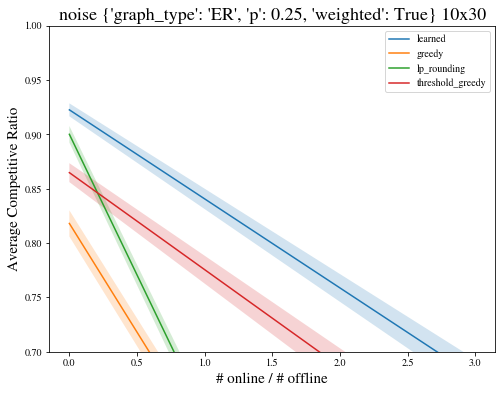

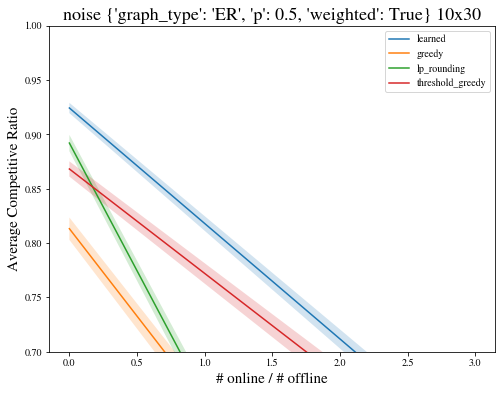

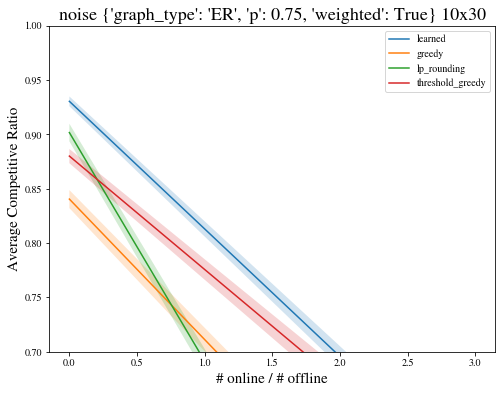

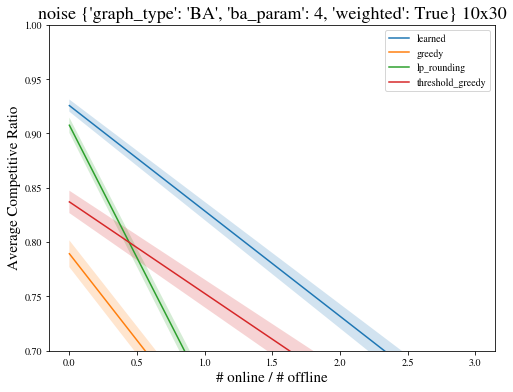

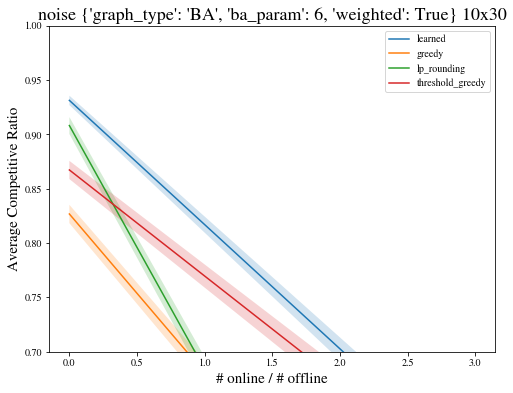

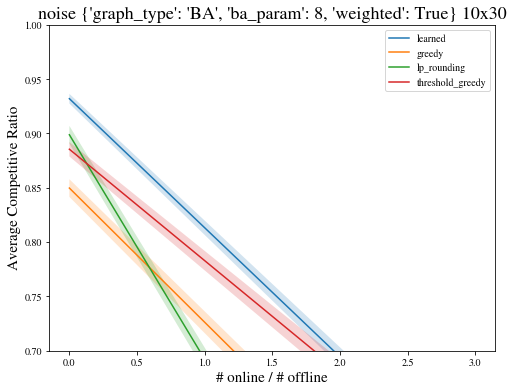

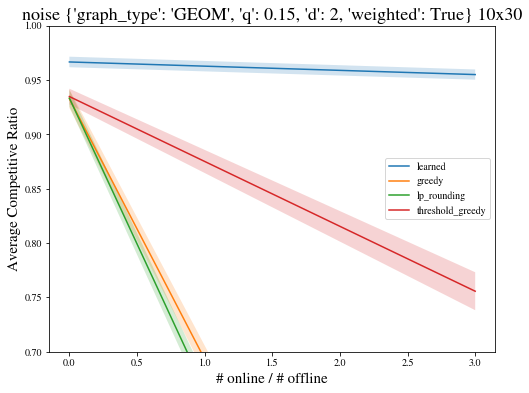

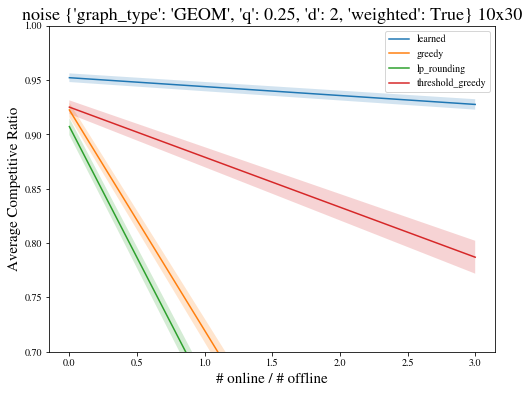

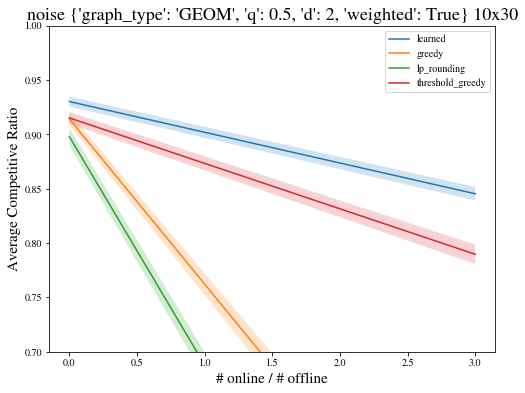

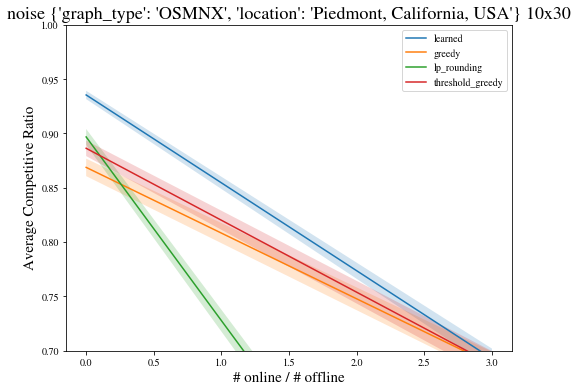

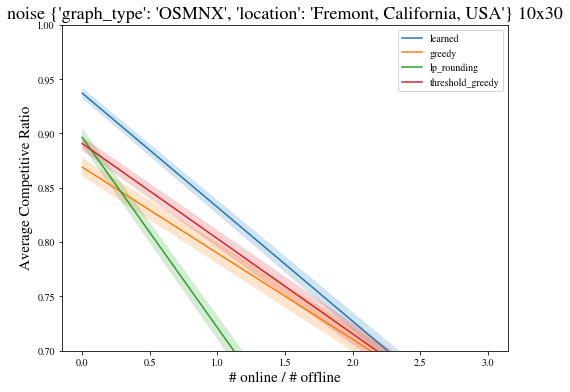

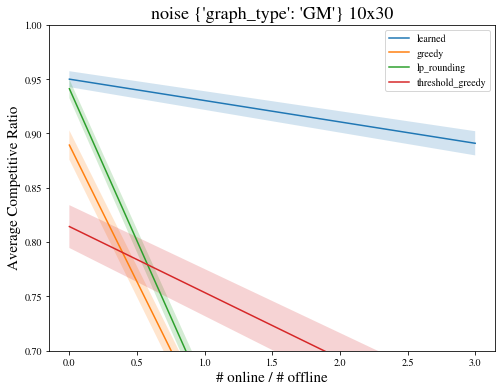

In [12]:
from util import _plot_approx_ratios
for graph_data, graph_config in zip(data, graph_configs):
	for node_config in node_configs:
		formatted_data = {graph_config['graph_type']: graph_data[node_config]}
		_plot_approx_ratios(noise_values, formatted_data, lambda graph_type: f"noise {graph_config} {node_config[1]}x{node_config[0]}", confidence = 0.95)

## FEAT graph evaluation

In [ ]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.9,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.95,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    # plt.savefig(f"data/{title}.png")
    plt.show()


## OSMNX evaluation

In [ ]:
num_trials = 30
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]

graph_configs = [
    {
        'graph_type': 'OSMNX',
        'location_graph': piedmont['location_graph'],
        'city': piedmont['city']
    },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': carmel['location_graph'],
    #     'city': carmel['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': geneva['location_graph'],
    #     'city': geneva['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': founex['location_graph'],
    #     'city': founex['city']
    # },
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['city']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        thresholded_greedy_ratios = [0]

        data[graph_config['city']].append(np.array(
            [
                gnn_learned_ratios,
                thresholded_greedy_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
print(ratios)
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[2]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[3]).mean())
        

    title = f"OSMNX_discard_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()



## Graph transferability

In [4]:
GNN, args = load('GNN2_hyperparam_tuned', device)

In [8]:
import gnn_library.util as util
num_trials = 40
node_configs = [(2*x, x) for x in np.arange(10, 40, 4)]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]


threshold = 0.35 # TODO set up value
t_greedy = OBM_Threshold_Greedy(threshold) 


graph_configs = util.graph_configs_standard

sizes = [x for (x,y) in node_configs]
print(sizes)

data = [[] for _ in range(len(graph_configs))]
for data_index, graph_config in enumerate(graph_configs):
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)


        rng = np.random.default_rng(seed)

        cr_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        t_greedy_ratio, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[t_greedy],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
        )

        cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

        data[data_index].append(cr_ratios)

[20, 28, 36, 44, 52, 60, 68, 76]
(20, 10) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(28, 14) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(36, 18) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
(44, 22) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}


/home/alexhay/GNN-OBM/algorithms.py:257: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix


(52, 26) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}


In [ ]:
import pickle

with open(f"saved_runs/transferability_gnn2.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

with open(f'saved_runs/transferability_gnn2.pickle', 'rb') as handle:
    data_copy = pickle.load(handle)

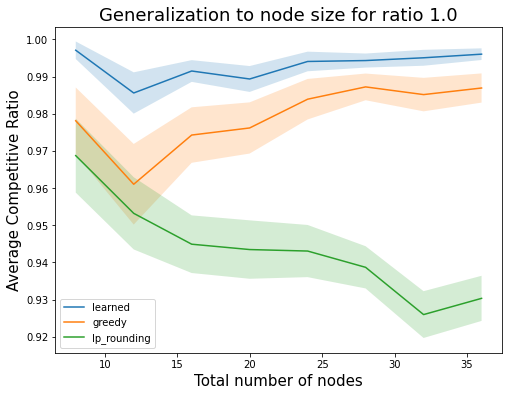

In [23]:
from util import _plot_approx_ratios
for graph_config, graph_data in data:
	_plot_approx_ratios(sizes, graph_data, lambda graph_type: f"Generalization to node size for ratio {2}", x_axis_name= "Number of online nodes", confidence = 0.95)

In [ ]:
import matplotlib.pyplot as plt

sizes = [x for (x,_) in node_configs]

aggregated_ratios = {}
for q, comp_ratios in data.items():
    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

fig = plt.figure(figsize=(8,6))
for model, ratios in aggregated_ratios.items():
    plt.plot(sizes, ratios, label=model)

title = f"16_01_2024_graph_transferability_{q}"
plt.title("Graph transferability NxN ratio - trained on 8x8")
plt.xlabel('Number of online nodes')
plt.ylabel('Average competitive ratio')
plt.legend()
plt.savefig(f"data/{title}.png")
plt.show()
